In [275]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumCircuit
from qiskit.primitives import BackendEstimator
from qiskit_ibm_runtime import QiskitRuntimeService
 
# Load saved credentials
service = QiskitRuntimeService()


In [286]:
print(edgelists)

[[(0, 1), (1, 2)], [(0, 1), (1, 2), (1, 3), (2, 4), (3, 4)], [(0, 1), (1, 2), (1, 3), (2, 4), (3, 4), (3, 5)], [(0, 1), (1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (3, 5), (4, 5), (5, 6)]]


In [287]:
edgelists = [[(0, 1), (1, 2)], 
             [(0, 1), (1, 2), (1, 3), (2, 4), (3, 4)],
             [(0, 1), (1, 2), (1, 3), (2, 4), (3, 4), (3, 5)], 
             [(0, 1), (1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (3, 5), (4, 5), (5, 6)]]
G_set = [nx.from_edgelist(edgelist) for edgelist in edgelists]

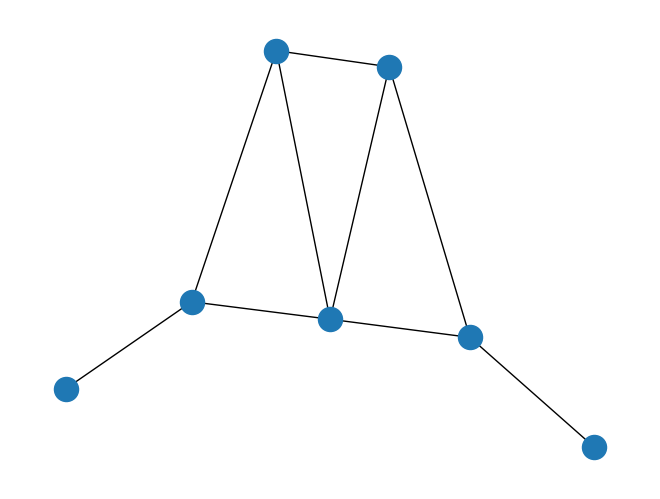

In [289]:
nx.draw(G_set[3])

For a graph $G = (V,E)$, with n vertices, V = $\{ v_1, v_2, v_3 ... v_n \}$, and m edges, E = $\{ e_1, e_2, e_3 ... e_m \}$, also for each edge $e_k \in E$, we define $e_k = (v_i,v_j)$ where $v_i, v_j \in V$. Since our graphs are undirected, the ordering does not matter. Each vertices represent a qubit, with $X_{i} \in \{0,1\}, \forall i \in n$. We have the coefficients, $J, h > 0$, 


\begin{equation}
H_c = \sum_{(v_i,v_j) \in E} J X_{v_i}^z X_{v_j}^z - \sum_{v_j \in V} h X_{v_j}^z
\end{equation}

We want to map $X_i$ to our Pauli-Z operators, using $X_i = \frac{1-\sigma^Z_{i}}{2}$ as our mapping from the range $\{0,1\}$ to $\{1,-1\}$. Hence, the Hamiltonian that we want to implement now becomes

\begin{align}
H_c &= J \sum_{(v_i,v_j) \in E}  \frac{1-\sigma^Z_{v_i}}{2} \frac{1-\sigma^Z_{v_j}}{2} - h \sum_{v_j \in V}  \frac{1-\sigma^Z_{i}}{2} \\
&= J \sum_{(v_i,v_j) \in E}  \frac{1 - \sigma^Z_{i} - \sigma^Z_{j} + \sigma^Z_{i}\sigma^Z_{j} }{4} - h \sum_{v_j \in V}  \frac{1-\sigma^Z_{i}}{2} \\
&= \frac{J}{4} \sum_{(v_i,v_j) \in E} \sigma^Z_{i}\sigma^Z_{j} - \frac{J}{4} \sum_{(v_i,v_j) \in E} (\sigma^Z_{i} + \sigma^Z_{j}) +  \frac{h}{2} \sum_{v_j \in V}  \sigma^Z_{j} \\
\end{align}

In the last step, constant terms were ignored, and we only focus on the operators. Given this construction, we see that while we can easily implement $RZZ$ gates proportional to $\frac{J}{4}$, but to accurately implement the $RZ$ part, we could compute the angles needed on each qubit depending on the sums of several $-\frac{J}{4}$ terms and one $h$ term depending on graph topology.

To minimze this Hamiltonian, ideally we should have $J > h$, as any constraint violation is undesriable, and only when constraints are satisfied, we might want to optimize for more $|1>$ states. For now a guesstimate might be to set $J = 8$ and $h = 3$.

In [290]:
#CONSTANTS
J = 8
h = 3

Here we have our objective function, which returns the hamiltonian and the value to the MIS problem, as well as whether a candidate solution is valid or not. Note here we use an indexing from left to right, with the bitstring mapping to the edges as $V_0 V_1 \cdots V_n$, this is in contrarary to how qiskit will present the results later, which employs a right to left counting system. 

In [291]:
def MIS_obj(x, G):
    '''
    Given a bitstring as a solution, return if this is a valid solution to the MIS problem, and the cardinality of the set
    Args:
        x: str
            solution bitstring, same length as nodes in G
        G: network x graph
    Returns:
        validity: Bool
            Whether solution is valid
        energy_value: float
            MIS Hamiltonian
        obj: int
            Objective value of the MIS problem -- cardinality of independent set
    '''
    if len(G.nodes) != len(x):
        raise Exception("Solution Bitstring is not the same length as Graph, try again!")
    
    validity = True 
    obj = 0
    energy_value = 0

    sols = [bool(int(i)) for i in x]
    #Check if set is independent
    for v_i,v_j in G.edges:
        if (sols[v_i] and sols[v_j]) == True:
            validity = False
    #If it is, count again, if invalid, objective value is 0
    if validity == True: obj = np.sum(sols)
    #Compute Hamiltonian
    for v_i,v_j in G.edges:
        energy_value += J * sols[v_i] * sols[v_j]
    for v_i in G.nodes:
        energy_value += -h * sols[v_i]

    return validity,obj, energy_value

def create_graph(n: int, m:int):
    G = nx.barabasi_albert_graph(n = n, m = 2, seed = 42)
    pos = nx.spring_layout(G, iterations= 60)
    return(G,pos)

In [292]:
# Input, a network x Graph
def create_qc(beta, gamma, G):
    """
    Create a QAOA circuit parametized by beta and gamma for solving the MIS problem on a graph G

    Input:
        beta: list of floats
            set of parameters for the mixing hamiltonian
        gamma: list of floats
            set of parameters for the cost hamiltonian
        G: network X graph
            problem of interest
    Output;
        G: network X graph
        qc: qiskit.QuantumCircuit
            QAOA circuit to be ran and measured
    """
    num_layer = len(beta)
    graph_size = len(G.nodes)
    # Output, quantum circuit
    qc = QuantumCircuit(graph_size)
    # Initial: Hadamarding
    qc.h(range(graph_size))
    # Create H_C: Cost Hamiltonian, in P_Z basis, rotate parametized by gamma
    for i, layer in enumerate(range(num_layer)):
        #Implement H_C -- cost hamiltonian
        degree_count = np.zeros(len(G.nodes))
        for v_i,v_j in G.edges:
            qc.rzz(J*gamma[i]/4,v_i,v_j)
            degree_count[v_i] += 1
            degree_count[v_j] += 1
        for v_i in G.nodes:
            qc.rz(gamma[i]*(h/2 - J/4*degree_count[v_i]), v_i)
        #Implement H_B -- mixing hamiltonian
        for v_j in G.edges:
            qc.rx(2*beta[i], v_j)
    qc.measure_all()
    return G,qc

In [293]:
from qiskit.primitives import Sampler

def run_circuit(qc):
    job = Sampler().run(qc)
    result = job.result()
    solutions = [q.binary_probabilities() for q in result.quasi_dists]
    probs = np.array(list(solutions[0].values()))
    hamiltonian = []
    for i in solutions[0].keys():
        i_flipped = i[::-1]
        validity,obj, energy_value = MIS_obj(i_flipped, G)
        hamiltonian.append(energy_value)
    expected_H_c = np.dot(np.array(hamiltonian),probs)
    return {"objective_value": expected_H_c, 
            "measurment outcomes": solutions}

def get_expected_energy(beta,gamma,G):
    G,qc = create_qc(beta,gamma, G)
    output = run_circuit(qc)
    return output["objective_value"]

#Quick sanity check, random gamma and betas
get_expected_energy([0.5,0.6],[0.4,0.5], G)

7.32498237779606

In [298]:
import scipy.optimize
from math import pi
#Optimize params
G = G_set[1]
res = scipy.optimize.minimize(
        lambda x: get_expected_energy([x[0],x[1]],[x[2],x[3]],G),x0 = (0.3,0.2,0.4,0.1),
        method='SLSQP', bounds=[(0,pi),(0,pi),(0,2*pi),(0,2*pi)])
G,qc = create_qc(res.x[0:2],res.x[2:4],G)
output = run_circuit(qc)

In [299]:
best_sol = np.where(list(output['measurment outcomes'][0].values()) == max(list(output['measurment outcomes'][0].values())))[0][0]
optimal_solution = list(output['measurment outcomes'][0].keys())[best_sol]
MIS_obj(optimal_solution[::-1],G)

(True, 2, -6)

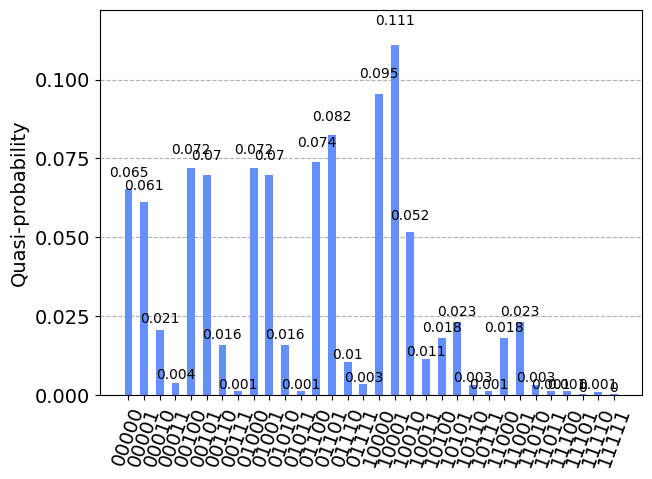

In [300]:
from qiskit.visualization import plot_distribution
plot_distribution(output['measurment outcomes'])